# Previsão de renda

### 4 elementos importantes
- Esse notebook
- Streamlit com as análises
- Seu Github com o projeto
- Vídeo no readme do github mostrando o streamlit

## Etapa 1 CRISP - DM: Entendimento do negócio

* Utilizando desse dataframe com informações sobre o cliente como *escolaridade*, *posses*, *estado civil* entre outros, faremos um modelo de regressão logística para saber quais fatores importam mais, tanto positivamente quanto negativamente para o cliente vir a possuir tanto uma casa quanto um carro.


## Etapa 2 Crisp-DM: Entendimento dos dados

### Dicionário de dados
*(Dados com a tipagem em <span style="color:red">vermelho</span> terão seus tipos alternados no futuro para melhor maneabilidade nos dados)*

| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Janeiro 2015 até Março 2016                        | <span style="color:red">object</span>|
| id_cliente              |  Identificação do cliente                           | Int64|
| sexo                    |  Genêro do Cliente                                  |<span style="color:red">object</span>|
| posse_de_veiculo        |  Se o cliente possui um veiculo                     |bool|
| posse_de_imovel         |  Se o cliente possui um imovel                      | bool|
| qtd_filhos              |  Quantidade de filhos do cliente                    | int64|
| tipo_renda              |  Tipo de renda do cliente                           | <span style="color:red">object</span>|
| educacao                |  Nível de escolaridade do cliente                   | <span style="color:red">object</span>|
| estado_civil            |  Estado civil do cliente                            | <span style="color:red">object</span>|
| tipo_residencia         |  Tipo de residencia do cliente                      | <span style="color:red">object</span>|
| idade                   |  Idade do cliente                                   | int64|
| tempo_emprego           |  Tempo em que o cliente não se encontra desempregado| float64|
| qt_pessoas_residencia   |  Quantidade de pessoas que moram na mesma residencia do cliente | float64|
| renda                   |  Renda mensal do cliente                            | float64|

#### Carregando os pacotes

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [2]:
#Lendo Dataframe
renda = pd.read_csv('./input/csv/previsao_de_renda.csv')

#### Entendimento dos dados - Univariada
Nesta etapa tipicamente avaliamos a distribuição de todas as variáveis, para isso utilizarei da biblioteca *ydata_profiling* criando um arquivo html de visualização rápida e fácil.


In [3]:
# Criando o arquivo
prof = ProfileReport(renda, explorative=True, minimal=True)

#Salvando o arquivo na pasta output
prof.to_file('./output/renda_analisys.html')

#Demonstrando o arquivo, possui maior utilidade se visto em uma guia própria por meio do download.
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

* Descobertas
  
1. Número de células faltantes: **2573 (1.1% de todo Dataframe)**.

2. Todas as células falantes se encontram em *tempo_emprego*. (17.2% de tempo_emprego)

3. Coluna **Unnamed: 0** que deve ser excluída.

4. Podemos ver que existem linhas *repetidas*, que não se mostrarão *repetidas* por conta da coluna **"Unnamed: 0"** que atribui um valor único crescente para cada linha

In [4]:
# Ordenando o DataFrame pelo índice (id_cliente) em ordem crescente
renda.set_index('id_cliente', inplace=True)
renda.sort_index(inplace=True)


#Contagem de células vazias
contagem_nan = renda.isna().sum()
print('Dados faltantes:')
print(contagem_nan,'\n')

num_linhas = renda.shape[0]

# Imprimindo o número de linhas
print(f'Número de Linhas: {num_linhas}')

# Exibindo o DataFrame resultante
renda.head()

Dados faltantes:
Unnamed: 0                  0
data_ref                    0
sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos                  0
tipo_renda                  0
educacao                    0
estado_civil                0
tipo_residencia             0
idade                       0
tempo_emprego            2573
qt_pessoas_residencia       0
renda                       0
dtype: int64 

Número de Linhas: 15000


,Unnamed: 0,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
id_cliente,,,,,,,,,,,,,,
1,9064,2015-10-01,F,False,True,0,Empresário,Secundário,Solteiro,Casa,52,8.358904,1.0,1938.57
1,7077,2015-08-01,F,False,True,0,Empresário,Secundário,Solteiro,Casa,52,8.358904,1.0,1938.57
2,9212,2015-10-01,F,False,True,0,Empresário,Secundário,Solteiro,Casa,52,8.358904,1.0,5702.28
2,7377,2015-08-01,F,False,True,0,Empresário,Secundário,Solteiro,Casa,52,8.358904,1.0,5702.28
3,5419,2015-06-01,M,True,True,0,Assalariado,Superior completo,Casado,Casa,46,2.106849,2.0,8534.70


### Entendimento dos dados - Bivariadas




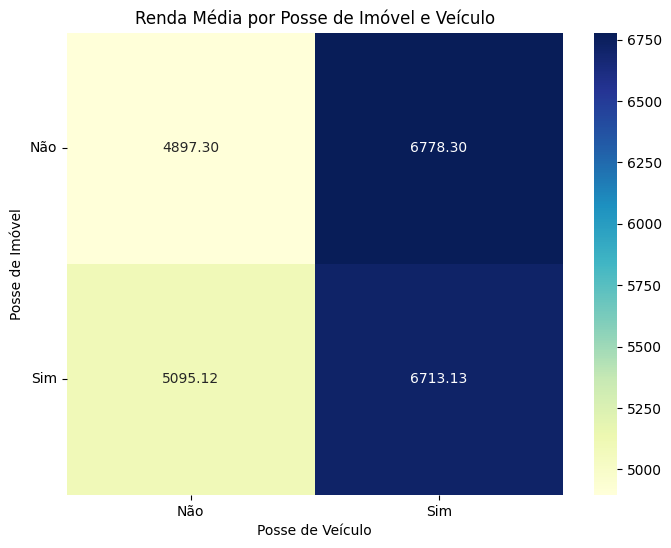

In [5]:
# Calculando a renda média agrupada por posse de imóvel e veículo, por ser a base do estudo que pretendemos realizar
renda_media_comb = renda.groupby(['posse_de_imovel', 'posse_de_veiculo'])['renda'].mean().unstack()

# Gráfico de calor
plt.figure(figsize=(8, 6))
sns.heatmap(renda_media_comb, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Renda Média por Posse de Imóvel e Veículo')
plt.xlabel('Posse de Veículo')
plt.ylabel('Posse de Imóvel')
plt.xticks(ticks=[0.5, 1.5], labels=['Não', 'Sim'])
plt.yticks(ticks=[0.5, 1.5], labels=['Não', 'Sim'], rotation=0)
plt.show()

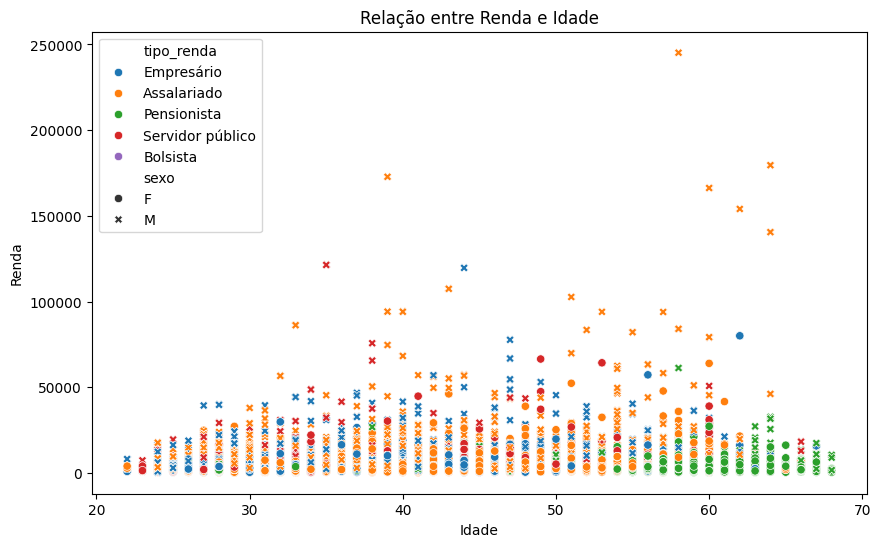

In [6]:
# Relação entre Renda e Idade por diferentes Escolaridades com intuito de buscar outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=renda, x='idade', y='renda', hue='tipo_renda', style='sexo')
plt.title('Relação entre Renda e Idade')
plt.xlabel('Idade')
plt.ylabel('Renda')
plt.show()

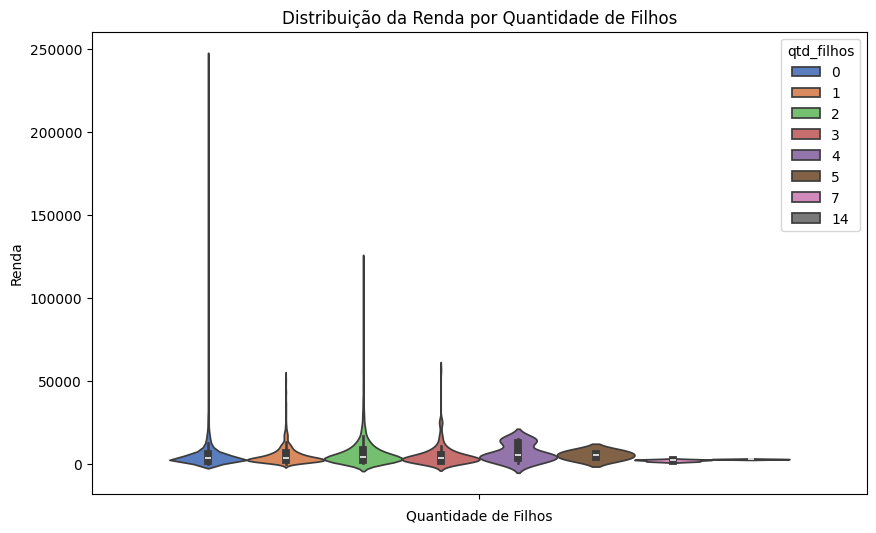

In [7]:
# Relação de renda por quantidade de filhos com intuito de buscar outliers

plt.figure(figsize=(10, 6))
sns.violinplot(data=renda, hue='qtd_filhos', y='renda', palette='muted')
plt.title('Distribuição da Renda por Quantidade de Filhos')
plt.xlabel('Quantidade de Filhos')
plt.ylabel('Renda')
plt.show()

In [8]:
# Calcular média e desvio padrão
media_renda = renda['renda'].mean()
desvio_padrao_renda = renda['renda'].std()

# Definindo limites para outliers
limite_inferior = media_renda - 10 * desvio_padrao_renda
limite_superior = media_renda + 10 * desvio_padrao_renda

# Identificando outliers
outliers = renda[(renda['renda'] < limite_inferior) | (renda['renda'] > limite_superior)]

print("Outliers encontrados:")
print(outliers)

Outliers encontrados:
            Unnamed: 0    data_ref sexo  posse_de_veiculo  posse_de_imovel  \
id_cliente                                                                   
3122             11535  2015-12-01    M              True            False   
6412               474  2015-01-01    M             False            False   
6609              5413  2015-06-01    M              True            False   
6611              8181  2015-09-01    M              True            False   
7725              9428  2015-10-01    M              True             True   
7863              3301  2015-04-01    M              True             True   
8728             10697  2015-11-01    M              True            False   
8728              4633  2015-05-01    M              True            False   
9588              5168  2015-06-01    M              True             True   
9590              3577  2015-04-01    M              True             True   
9590             11460  2015-12-01    M   

* Insights

1. **Foi percebido a existência de *outliers* no meio do código, o que pode prejudicar**

*(para realização dos testes sobre outliers foi utilizado pessoas com o valor de **10** ou mais vezes o desvio padrão, para baixo ou para cima (geralmente 2 a 4), o motivo de uma margem tão alta escolhida é porque a renda é algo muito volátil e que depende de muitas variáveis)*

2. Quanto maior a **quantidade de bens**, maior tende a ser a **renda** da pessoa.

## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



**Seleção**

Modificaremos o tipo das variáveis que estavam marcados de vermelho no começo para podermos continuar com mais facilidade

In [9]:
renda['data_ref'] = pd.to_datetime(renda['data_ref'])
renda = renda.astype({col: 'string' for col in renda.select_dtypes(include=['object']).columns})
renda.dtypes

Unnamed: 0                        int64
data_ref                 datetime64[ns]
sexo                     string[python]
posse_de_veiculo                   bool
posse_de_imovel                    bool
qtd_filhos                        int64
tipo_renda               string[python]
educacao                 string[python]
estado_civil             string[python]
tipo_residencia          string[python]
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
dtype: object

**Limpeza**

Excluiremos os dados faltantes que foram verificados anteriormente

In [10]:
renda = renda.dropna()
renda = renda.drop(columns=['Unnamed: 0'], errors='ignore')

contagem_nan = renda.isna().sum()
print('Contagem de celulas faltantes:\n')
print(contagem_nan)


duplicated_index = renda.index.duplicated(keep='first')

# Removendo todas as linhas com índices duplicados
renda_cleaned = renda[~duplicated_index]
renda = renda_cleaned

# Excluindo Outliers vistos anteriormente
renda = renda[(renda['renda'] >= limite_inferior) & (renda['renda'] <= limite_superior)]

# Exibindo o DataFrame resultante

print("\nDataFrame após remover todas as linhas com índices duplicados:\n")
renda.head()



Contagem de celulas faltantes:

data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

DataFrame após remover todas as linhas com índices duplicados:



,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
id_cliente,,,,,,,,,,,,,
1,2015-10-01,F,False,True,0,Empresário,Secundário,Solteiro,Casa,52,8.358904,1.0,1938.57
2,2015-10-01,F,False,True,0,Empresário,Secundário,Solteiro,Casa,52,8.358904,1.0,5702.28
3,2015-06-01,M,True,True,0,Assalariado,Superior completo,Casado,Casa,46,2.106849,2.0,8534.70
4,2015-05-01,F,True,False,0,Assalariado,Superior incompleto,Casado,Casa,29,3.021918,2.0,3087.85
5,2015-07-01,F,True,False,0,Assalariado,Superior incompleto,Casado,Casa,29,3.021918,2.0,690.39


**Construção**

Para facilitar, sera criada uma nova coluna **"posse_imovel_e_veiculo** para clientes que possuam tanto *veiculo* quanto *imóvel*

In [11]:
renda = renda.copy()

# Criando a nova coluna 'posse_imovel_e_veiculo' de forma segura
renda['posse_imovel_e_veiculo'] = renda['posse_de_imovel'] & renda['posse_de_veiculo']

# Criando a nova coluna "Genitor_solteiro"
renda['genitor_solteiro'] = (renda['qtd_filhos'] > 0) & (renda['estado_civil'] == 'Solteiro')


# Exibindo a contagem 
contagem_posses = renda[['posse_imovel_e_veiculo']].value_counts()
contagem_genitores = renda[['genitor_solteiro']].value_counts()

# Somando o total das combinações


print(contagem_posses)
print('\n')
print(contagem_genitores)

posse_imovel_e_veiculo
False                     5878
True                      2269
Name: count, dtype: int64


genitor_solteiro
False               7959
True                 188
Name: count, dtype: int64


**Integração**

Como utilizaremos de apenas *1 banco de dados* a parte de integração não será necessária.

**Formatação**

Os dados já se encontram no formato correto, porém utilizaremos essa seção para reorganizar a ordem das colunas no *dataframe ficando agrupado:

1. Informações de trabalho
2. Informações pessoais
3. Posses
4. Residencia

In [12]:
# Definindo a nova ordem das colunas
nova_ordem = ['data_ref','renda','tipo_renda','tempo_emprego','sexo','idade','educacao','estado_civil','qtd_filhos','genitor_solteiro', 'posse_de_imovel','posse_de_veiculo', 'posse_imovel_e_veiculo','tipo_residencia','qt_pessoas_residencia']

# Reordenando as colunas
renda = renda[nova_ordem]

renda.head(2)

,data_ref,renda,tipo_renda,tempo_emprego,sexo,idade,educacao,estado_civil,qtd_filhos,genitor_solteiro,posse_de_imovel,posse_de_veiculo,posse_imovel_e_veiculo,tipo_residencia,qt_pessoas_residencia
id_cliente,,,,,,,,,,,,,,,
1,2015-10-01,1938.57,Empresário,8.358904,F,52,Secundário,Solteiro,0,False,True,False,False,Casa,1.0
2,2015-10-01,5702.28,Empresário,8.358904,F,52,Secundário,Solteiro,0,False,True,False,False,Casa,1.0


In [13]:
#Salvando um novo arquivo html de visualização, dessa vez com o novo dataframe
prof = ProfileReport(renda, explorative=True, minimal=True)
prof.to_file('./output/renda_analisys_ajustada.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


### Rodando o modelo


* Modelo utilizado: Regressão Logística

Essa análise permitirá entender quais fatores (variáveis) têm maior impacto na posse de um imóvel e veículo. Com essa informação, uma empresa pode tomar decisões informadas sobre marketing, ofertas de produtos e segmentação de clientes.

In [14]:
# Transformando variáveis categóricas em dummies
renda_dummies = pd.get_dummies(renda, columns=['sexo', 'tipo_renda', 'estado_civil','educacao','tipo_residencia'], drop_first=True)

# Separando as variáveis de features e target
X = renda_dummies.drop(['data_ref', 'posse_imovel_e_veiculo'], axis=1)  # Features
y = renda_dummies['posse_imovel_e_veiculo']  # Target

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

# Criando e treinando o modelo de regressão logística
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

# Avaliando o modelo
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Coeficientes do modelo
coefficients = pd.DataFrame(model.coef_[0], index=X.columns, columns=['coeficiente'])
print(coefficients.sort_values(by='coeficiente', ascending=False))



[[1174    1]
 [   0  455]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1175
        True       1.00      1.00      1.00       455

    accuracy                           1.00      1630
   macro avg       1.00      1.00      1.00      1630
weighted avg       1.00      1.00      1.00      1630

                               coeficiente
posse_de_veiculo                 10.171504
posse_de_imovel                   9.347811
qtd_filhos                        2.088258
educacao_Pós graduação            0.083126
tipo_residencia_Estúdio           0.029234
renda                             0.000026
tipo_renda_Bolsista              -0.011460
tempo_emprego                    -0.018696
tipo_renda_Pensionista           -0.040851
idade                            -0.070944
tipo_residencia_Comunitário      -0.166187
estado_civil_Viúvo               -0.241596
genitor_solteiro                 -0.248557
tipo_renda_Servidor público      -0.405869
s

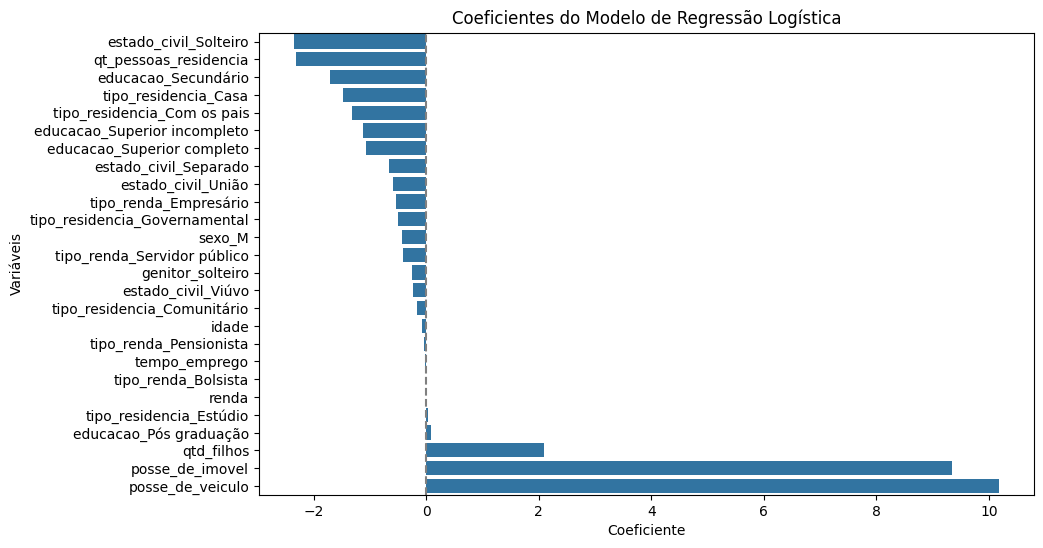

In [15]:
# Preparar os dados dos coeficientes para visualização
coeficientes = coefficients.sort_values(by='coeficiente')
plt.figure(figsize=(10, 6))
sns.barplot(x=coeficientes['coeficiente'], y=coeficientes.index)
plt.title('Coeficientes do Modelo de Regressão Logística')
plt.xlabel('Coeficiente')
plt.ylabel('Variáveis')
plt.axvline(0, color='grey', linestyle='--')  # Linha vertical em 0
plt.show()

## Etapa 5 Crisp-DM: Avaliação dos resultados


**Matriz de Confusão**


|1174|   1|
|----:|:----|
|   0|455|


1. True Negatives (TN): 1174 - Este é o número de vezes que o modelo previu corretamente que uma pessoa não possui tanto imóvel quanto veículo.

2. False Positives (FP): 1 - Este é o número de vezes que o modelo previu incorretamente que uma pessoa possui imóvel e veículo, mas na verdade não possui.

3. False Negatives (FN): 0 - Não houve previsões incorretas dizendo que uma pessoa não possui, quando na verdade possui.

4. True Positives (TP): 455 - O número de vezes que o modelo previu corretamente que uma pessoa possui imóvel e veículo.

**Métricas de Avaliação**

* Para False: 1.00 - 100% das vezes que o modelo previu que uma pessoa não possui imóvel e veículo, estava correto.
* Para True: 1.00 - 100% das vezes que o modelo previu que uma pessoa possui imóvel e veículo, estava correto.

**Recall (Sensibilidade)**

* Para False: 1.00 - O modelo identificou corretamente todas as pessoas que não possuem imóvel e veículo.
* Para True: 1.00 - O modelo identificou corretamente todas as pessoas que possuem imóvel e veículo.

**F1-Score:** Combinação harmônica de precisão e recall, todos com valor 1.00, mostrando que o modelo está perfeitamente balanceado nas suas previsões.

**Accuracy (Acurácia):** 1.00 - O modelo acertou 100% das previsões (1630 predições corretas no total).

**Variáveis com Coeficientes Positivos:**

* *Posse de veículo* (+10.19) e *posse de imóvel* (+9.40) têm os coeficientes mais altos, indicando uma forte influência positiva sobre a
probabilidade de a pessoa possuir imóvel e veículo.

* *Quantidade de filhos* (+2.11) indica que, conforme o número de filhos aumenta, a probabilidade de possuir imóvel e veículo também aumenta, embora de forma mais moderada.

* *Pós-graduação* (+0.08) aumenta a probabilidade, porém nada muito significativo em comparação com as outras variáveis acima

**Variáveis com Coeficientes Negativos:**

* *Estado civil: solteiro* (-2.38) tem um coeficiente negativo mais forte, sugerindo que pessoas solteiras têm menor probabilidade de possuir imóvel e veículo.
  
* Outras variáveis com impacto negativo relevante incluem *quantidade de pessoas na residencia* (-2.31) indicando que quanto mais pessoas morarem juntas do cliente menor a chance do mesmo adquirir um veiculo e um imóvel.

* Não só a quantidade de pessoas na casa mas também para *pessoas que moram com os pais* (-1.33) ou *com outros familiares* (-1.48) possuem uma probabilidade menor que adquirir um veiculo e um imóvel.

## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.

Utilizaremos o **Streamlit**, para isso iremos baixar o banco de dados já modificado e criar uma aplicação .py que funcione corretamente

In [16]:
renda.to_csv('input/csv/renda_ajustado.csv', index=True)

Utilize o arquivo *.py* que foi baixado junto desse notebook para abrir o **streamlit**.